In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import kagglehub
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import confusion_matrix
import statsmodels.formula.api as smf
from linearmodels.panel import PanelOLS
from linearmodels import PooledOLS, PanelOLS, RandomEffects
#Pentru normalitate
from statsmodels.stats.stattools import jarque_bera
from scipy.stats import shapiro 
from scipy.stats import kstest, norm
#Pentru Homoschedasticitate
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
#Pentru multicolinaritate
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [67]:
panel_df = pd.read_csv("World-happiness-report-updated_2024.csv",encoding='unicode_escape')

panel_df.rename(columns={
    'Log GDP per capita':'GDP_capita_logged',
    'Perceptions of corruption':'Coruption',
    'Healthy life expectancy at birth':'Life_expectancy_at_birth',
    'Social support':'Social_support',
    'Regional indicator':'Region',
    'Freedom to make life choices':'Freedom',
    'Life Ladder':'happy'
},inplace=True)
panel_df["Financial Crisis"] = 0
panel_df["Covid"] = 0
panel_df.loc[panel_df['year']==2008,'Financial Crisis'] = 1
panel_df.loc[panel_df['year']==2020,'Covid'] =1 
panel_df.set_index(["Country name","year"],inplace=True)

In [63]:
panel_df.head()


,Country name,year,happy,GDP_capita_logged,Social_support,Life_expectancy_at_birth,Freedom,Generosity,Coruption,Positive affect,Negative affect,Financial Crisis,Covid
0,Afghanistan,2008,3.724,7.350,0.451,50.5,0.718,0.164,0.882,0.414,0.258,1,0
1,Afghanistan,2009,4.402,7.509,0.552,50.8,0.679,0.187,0.850,0.481,0.237,0,0
2,Afghanistan,2010,4.758,7.614,0.539,51.1,0.600,0.118,0.707,0.517,0.275,0,0
3,Afghanistan,2011,3.832,7.581,0.521,51.4,0.496,0.160,0.731,0.480,0.267,0,0
4,Afghanistan,2012,3.783,7.661,0.521,51.7,0.531,0.234,0.776,0.614,0.268,0,0


In [5]:
# !pip install linearmodels

In [79]:
variabile_model = ['GDP_capita_logged','Social_support','Freedom','Coruption']
X = panel_df[variabile_model]
y = panel_df['happy']
X = sm.add_constant(X)

In [72]:
model_panel = PooledOLS(y,X)
model_efecte_random = RandomEffects(y,X).fit(cov_type='clustered')
rezultat = model_panel.fit(cov_type='clustered',cluster_entity=True)

d:\anaconda\Lib\site-packages\linearmodels\panel\model.py:919: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
d:\anaconda\Lib\site-packages\linearmodels\panel\model.py:2751: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


In [73]:
rezultat.summary

Dep. Variable:,happy,R-squared:,0.7348
Estimator:,PooledOLS,R-squared (Between):,0.8065
No. Observations:,2190,R-squared (Within):,0.2265
Date:,"Tue, Dec 23 2025",R-squared (Overall):,0.7348
Time:,21:36:28,Log-likelihood,-1921.0
Cov. Estimator:,Clustered,,
,,F-statistic:,1210.5
Entities:,158,P-value,0.0000
Avg Obs:,13.861,Distribution:,"F(5,2184)"
Min Obs:,1.0000,,
Max Obs:,18.000,F-statistic (robust):,185.11


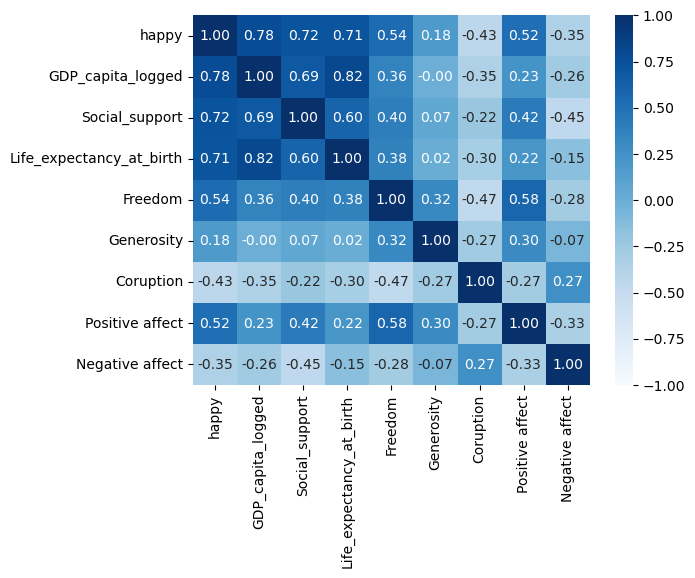

In [15]:
corr = panel_df.corr()
sns.heatmap(corr, annot=True,fmt='.2f',vmax=1,vmin=-1,cmap='Blues')
plt.show()

In [74]:
from scipy import stats
# 1. Fit Pooled OLS
pooled = PooledOLS(y, X).fit()

# 2. Calculate Breusch-Pagan LM Test
# Get residuals
resids = pooled.resids
n = y.index.levels[0].size  # Number of entities
t = y.index.levels[1].size  # Number of time periods

# Group residuals by entity and sum them
# Note: Ensure your index is (entity, time)
grouped_resids = resids.groupby(level=0).sum()
lm_stat = (n * t) / (2 * (t - 1)) * (np.sum(grouped_resids**2) / np.sum(resids**2) - 1)**2
p_value = stats.chi2.sf(lm_stat, 1)

print(f"BP LM Statistic: {lm_stat:.4f}")
print(f"p-value: {p_value:.4f}")

BP LM Statistic: 6057.4771
p-value: 0.0000


d:\anaconda\Lib\site-packages\linearmodels\panel\model.py:919: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


In [47]:
def hausman_test(fe_model, re_model):
    # Extract coefficients (b) and covariance matrices (v)
    # We only compare coefficients that exist in both models (usually excluding the constant)
    common_coefs = [v for v in fe_model.params.index if v in re_model.params.index]
    
    b_fe = fe_model.params[common_coefs]
    b_re = re_model.params[common_coefs]
    v_fe = fe_model.cov.loc[common_coefs, common_coefs]
    v_re = re_model.cov.loc[common_coefs, common_coefs]
    
    # Calculate the test statistic: (b_fe - b_re)' * inv(v_fe - v_re) * (b_fe - b_re)
    diff = b_fe - b_re
    cov_diff = v_fe - v_re
    
    # Use the Moore-Penrose pseudo-inverse for better numerical stability
    precision = np.linalg.pinv(cov_diff)
    chi2 = diff.T @ precision @ diff
    
    # Degrees of freedom = number of coefficients compared
    df = len(common_coefs)
    p_val = stats.chi2.sf(chi2, df)
    
    return chi2, df, p_val

In [81]:
fe = PanelOLS(y,X,entity_effects=True,time_effects=True).fit()
re = RandomEffects(y,X).fit()
chi2, df, p_values = hausman_test(fe,re)
print(p_values)

0.6541861365064578


d:\anaconda\Lib\site-packages\linearmodels\panel\model.py:1258: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
d:\anaconda\Lib\site-packages\linearmodels\panel\model.py:2751: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


In [83]:
final_model = PanelOLS(y, X, entity_effects=True, time_effects=True).fit(
    cov_type='clustered', 
    cluster_entity=True
)
final_model.summary

d:\anaconda\Lib\site-packages\linearmodels\panel\model.py:1258: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Dep. Variable:,happy,R-squared:,0.2322
Estimator:,PanelOLS,R-squared (Between):,0.7950
No. Observations:,2190,R-squared (Within):,0.2329
Date:,"Tue, Dec 23 2025",R-squared (Overall):,0.7281
Time:,21:45:41,Log-likelihood,-833.39
Cov. Estimator:,Clustered,,
,,F-statistic:,151.92
Entities:,158,P-value,0.0000
Avg Obs:,13.861,Distribution:,"F(4,2010)"
Min Obs:,1.0000,,
Max Obs:,18.000,F-statistic (robust):,27.555
